<h3>1. Build custom RandomSearchCV</h3>

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

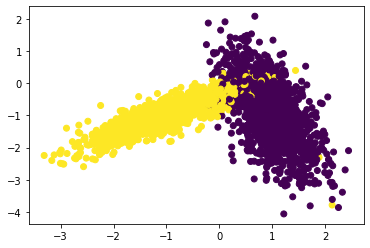

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# colors = {0:'red', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=y_test)
plt.show()

In [ ]:
print(len(X_train))
print(len(y_train))

7500
7500


In [ ]:
# check representation of classes in test dataset
print(np.count_nonzero(y_test == 0))
print(np.count_nonzero(y_test == 1))

1246
1254


In [ ]:
# define function to generate 10 unique values (uniform random distribution) in the given range "param_range" and store them as "params"

def list_of_param_values(mytuple):
  a, b = mytuple
  return random.sample(range(a,b), 10)

In [ ]:
test = (1,50)
random.seed(60)
list_of_param_values(test)

[20, 19, 37, 10, 17, 15, 31, 30, 22, 3]

In [ ]:
# define custom RandomSearchCV function that takes the following as input:
  # - x_train: numpy array of shape, (n,d)
  # - y_train: numpy array of shape, (n,) or (n,1)
  # - classifier: KNeighborsClassifier() in this case
  # - param_range: tuple of (a,b) where a, b are integers (representing hyperparameter value) and a < b
  # - folds: number of folds (intefer) used for cross validation on training data
# output of function is hyperparameter values used, training accuracy score, CV accuracy score
# reference - https://stackoverflow.com/questions/61818704/building-a-custom-randomsearchcv-using-python

def RandomSearchCV(x_train, y_train, classifier, param_range, folds):
  train_scores = []
  test_scores = []

  # 1: Generate 10 unique values from given range and store in params
  params = list_of_param_values(param_range)
  params.sort()

  x_train_split = []
  y_train_split = []

  #2: divide x_train into groups based on no. of folds
  for i in range(0, len(x_train), int(len(x_train)/folds)): # if len(x_train) = 7500 and 3 folds, then 'for i in range(0, 7500, 2500)'
    x_train_split.append(x_train[i:i+int(len(x_train)/folds)]) # append sliced data arrays into x_train_split and y_train_split
    y_train_split.append(y_train[i:i+int(len(y_train)/folds)])

  #3: for each hyperparameter generated in step 1 and each group generated in step 2, perform cross validation 
  for paramvalue in params:
    trainscores_folds = []
    testscores_folds  = []
    
    # divide data into training and CV datasets
    for group in range(len(x_train_split)): # if 3 folds, then 'for i in range(3)'
      x_train_group = np.concatenate(x_train_split[0:group] + x_train_split[group+1:]) 
      x_cv_group = x_train_split[group]
      y_train_group = np.concatenate(y_train_split[0:group] + y_train_split[group+1:])
      y_cv_group = y_train_split[group]

      classifier.n_neighbors = paramvalue
      classifier.fit(x_train_group, y_train_group)

      y_predicted = classifier.predict(x_cv_group)
      testscores_folds.append(accuracy_score(y_cv_group, y_predicted))

      y_predicted = classifier.predict(x_train_group)
      trainscores_folds.append(accuracy_score(y_train_group, y_predicted))

  #4: return average of train and test scores
    train_scores.append(np.mean(np.array(trainscores_folds)))
    test_scores.append(np.mean(np.array(testscores_folds)))

  return params, train_scores, test_scores

In [ ]:
classifier = KNeighborsClassifier()
params, train_score, cv_scores = RandomSearchCV(X_train, y_train, classifier, param_range=(1,50), folds=3)

In [ ]:
# return hyperparameter values (k for KNN in this case)
params

[9, 10, 11, 20, 33, 36, 39, 40, 41, 47]

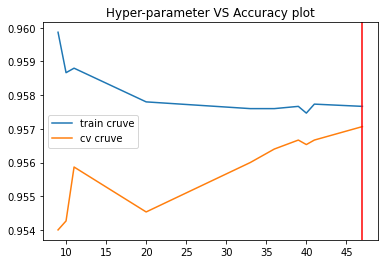

In [ ]:
plt.plot(params, train_score, label='train cruve')
plt.plot(params, cv_scores, label='cv cruve')
plt.title('Hyper-parameter VS Accuracy plot')
plt.axvline(x=47, color='r') # add a vertical red for best hyperparameter value 
plt.legend()
plt.show()

The best hyperparameter (k for KNN in this case) appears to be 47 based on the chart above, where the gap between the lines is the smallest.

<h3>2. Plot decision boundary</h3>

In [ ]:
# reference: https://colab.research.google.com/drive/13NoPSgtq_OEqFiUbAmzjVsbMWWUayofG#scrollTo=qGOKiuBnk0tJ

def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

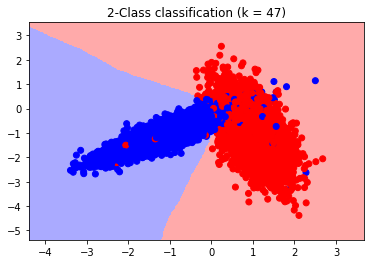

In [ ]:
# plot decision boundary
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = 47)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)

<h3>3. Extra: Compute accuracy scores for model initialized with best hyperparameter</h3>

In [ ]:
# compute accuracy score using model initialized with k=47
y_predicted = neigh.predict(X_test)
accuracy_score(y_test, y_predicted)

0.968

In [ ]:
# compute confusion matrix using model initialized with k=47
from sklearn.metrics import confusion_matrix
# confusion_matrix(y_test, y_predicted)
tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).ravel()

# print("The true positive rate (sensitivity) is", tp/(tp+fn))
print("The true positive rate (sensitivity) is %.2f" % (tp/(tp+fn)))
print("The true negative rate (specificity) is %.2f" % (tn/(tn+fp)))

The true positive rate (sensitivity) is 0.96
The true negative rate (specificity) is 0.98


Model accuracy on unseen data (test dataset) is 97%.
Sensitivity is 96% while specificity is 98%.

<h3>4. Extra: Perform sklearn RandomizedSearchCV for comparison</h3>

In [ ]:
# compare results of custom RandomSearchCV against sklearn RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

kneigh = KNeighborsClassifier()
dist = dict(n_neighbors=params)
clf = RandomizedSearchCV(kneigh, dist, random_state=60)
search = clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

{'n_neighbors': 47}
0.9573333333333334


The best hyperparameter is 47, matching the results from custom RandomSearchCV